In [ ]:
!mkdir /content/plots 
!mkdir /content/checkpoints

In [ ]:
class User_initialization(object):
    def __init__(self, user_config, train_config):
        self.id = user_config['id']
        self.M_u = user_config['M_u']
        self.P_u = user_config['P_u']
        self.F_u = user_config['F_u']
        self.t_factor = user_config['t_factor']
        self.penalty = user_config['penalty']
        self.sigma2 = train_config['sigma2']

In [ ]:
class Server_initialization(object):
    def __init__(self, server_config, train_config):
        self.id = server_config['id']
        self.rate = server_config ['id']
        self.dis = server_config['dis']
        self.F_e = server_config['F_e']
        self.t_factor = server_config['t_factor']
        self.penalty = server_config['penalty']
        self.sigma2 = train_config['sigma2']

In [ ]:
class MecSvrEnv(object):
    """
    Simulation environment
    """
    def __init__(self, user_list, server_list, sigma2): 
          self.user_list = user_list
          self.server_list = server_list
          self.num_user = len(user_list)
          self.num_server = len(server_list)
          self.sigma2 = sigma2
          self.count = 0
          alpha = -3 
          self.time_slot = 0
          self.seqCount = 0
          self.transmission = np.zeros(self.num_server)
          self.Computing_server = np.zeros(self.num_server)
          self.feedback = np.zeros(self.num_server)
          self.cellular_power = 0.2 # W
          distance_cellular = 0.3
          alpha = -3
          cell = []
          for i in range (2):
            X =(1/math.sqrt(2))*(pow(distance_cellular, alpha)* np.random.randn())
            Y =(1/math.sqrt(2))*(pow(distance_cellular, alpha)* np.random.randn())
            h= math.sqrt(pow(X,2) + pow(Y,2)) 
            cell.append(h)
          
          self.cellular_channel = cell[1]
          #self.cellular_power = np.random.randint(1,100)
          #self.cellular_channel=np.random.randint(1,50)
          self.f_user = np.random.randint(50,200,size=(1))# 1 egal a num_users cycles per second

          #self.f_servers = np.random.randint(100,500,size=( self.num_server)) 
          self.f_servers = np.zeros(self.num_server) # cycles per second
          self.f_servers[0]=600
          self.f_servers[1]=500
          self.f_servers[2]=500
          self.f_servers[3]=400
          self.f_servers[4]=300
          self.c = 20 # cycles per second
          #self.channels = np.random.randint(1,5,size=(self.num_server)) # h est le channel
          #self.channels = np.random.uniform(10,15,self.num_server) # h est le channel
          self.distances = [0.2,0.7,0.5,0.5,0.3,0.3]
          self.channels = []
          number = self.num_server + 1
          for i in range(number):
            X =(1/math.sqrt(2))*(pow(self.distances[i], alpha)* np.random.randn())
            Y =(1/math.sqrt(2))*(pow(self.distances[i], alpha)* np.random.randn())
            h = math.sqrt(pow(X,2) + pow(Y,2)) 
            self.channels.append(h)
          self.channels.pop(0)
          #print('channels',self.channels)
          #self.Powers = np.random.randint(10,30,size=( self.num_server))
          self.Powers = np.random.uniform(0,1,self.num_server)
          #print('self.Powers', self.Powers)
          self.SINR = 0
          self.Reward = 0         
          self.B = 10  #MHZ
          self.downlinks_Data_rates = np.zeros(shape = (self.num_server))
          local_CPU =0
          self.Data_rates = 0
          self.f_allocated = 0
          self.f_allocated_local = 0
          self.sinr_list = np.zeros(shape = (self.num_server))
          self.snr_list = np.zeros(shape = (self.num_server))






    def get_channels(self):
      channels = []
      alpha = -3 
      number = self.num_server + 1
      for i in range(number):
        X =(1/math.sqrt(2))*(pow(self.distances[i], alpha)* np.random.randn())
        Y =(1/math.sqrt(2))*(pow(self.distances[i], alpha)* np.random.randn())
        h = math.sqrt(pow(X,2) + pow(Y,2)) 
        channels.append(h)
      channels.pop(0)
      #print('channels',channels)
      return channels

      




    def find(self,element, vector):
      for i in range(len(vector)):
        if vector[i]== element:
            return i    
        
        
    def getCh(self):
        ch = np.random.choice(self.channels)
        server_id = self.find(ch,self.channels)
        return ch , server_id



    def Task_received_server(self, server_id, Task_size):
      self.Task_size = Task_size
      
      if server_id == 0:
        #self.f_allocated = np.random.randint(500,600)
        self.f_allocated = 550
      elif server_id == 1:
      #self.f_allocated = np.random.randint(300,400)
        self.f_allocated = 350

      elif server_id == 2:
        #self.f_allocated = np.random.randint(400,500)
        self.f_allocated = 450

      elif server_id == 3:
        #self.f_allocated = np.random.randint(300,400)
        self.f_allocated = 350

      elif server_id == 4:
        #self.f_allocated = np.random.randint(200,300)
        self.f_allocated = 250

      #f_allocated = self.c * self.Task_size
      return self.f_allocated


    def reset_f_servers(self, f_servers, server_id, sub_task ):
        self.f_servers = f_servers
        self.server_id = server_id
            #f(t) is a vector of remaining CPU - cycles frequency
        servers = self.f_servers[self.server_id]
        self.f_allocated = self.Task_received_server(self.server_id,self.sub_task ) 
        self.f_servers[self.server_id] = servers - self.f_allocated
        #print('nhina ', self.f_allocated,  "men ",servers)   
        #print('haw chel9ina', self.f_servers[self.server_id] )    
        if  self.f_servers[self.server_id] <0:
          self.f_servers[self.server_id] =1
        return self.f_servers, self.f_allocated

    def reset_f_servers_inverse(self,f_servers, server_id, f_allocated ):
        self.f_servers = f_servers
        self.server_id = server_id  
        self.f_allocated =   f_allocated

        self.f_servers[self.server_id] = self.f_servers[self.server_id] + self.f_allocated
        return self.f_servers


    def Task_exec_local(self,Task_size):
        self.Task_size = Task_size
        self.f_allocated_local= np.random.randint(2,20)

        #f_allocated_local= np.random.randint(2,10)* self.Task_size
        return self.f_allocated_local
 
    def reset_f_users(self, f_user, Task_size ):
        self.f_user = f_user
 
            #f(t) is a vector of remaining CPU - cycles frequency
        self.f_user = self.f_user - self.Task_exec_local(Task_size)       
        return self.f_user
    
    def reset_f_users_inverse(self, f_user,  f_allocated_local):
        self.f_user = f_user
        self.f_allocated_local = f_allocated_local
        self.f_user= self.f_user + self.f_allocated_local    
        return self.f_user


  # 
    def transmission_computing_server(self, server_id, f_allocated, sub_task, power, channels):
        self.channels = channels
        channel_server = self.channels[server_id]   
        self.sub_task = sub_task
        self.power = power
        no_executing = False
        self.f_allocated = f_allocated
        data_rates = self.uplink_data_rate(server_id,channel_server, power)
        #for i in range(self.num_user):
        
        data_rate_user = data_rates
        #print('data_rate_user', data_rate_user)
        #print('data_rates[server_id]', data_rates)
        if data_rates!= 0.0:
        #self.f_servers = self.reset_f_servers(self.f_servers, server_id, self.sub_task )
        #print('fservers',self.f_servers)
          self.transmission[server_id] = self.sub_task  / data_rate_user
        #self.f_allocated = self.Task_received_server( server_id, self.sub_task)
        #self.Computing_server[server_id]= (self.c * self.sub_task )/ self.f_servers[server_id]
      
          self.Computing_server[server_id]= (self.c * self.sub_task )/ self.f_allocated
        else :
          no_executing = True
          
          #return array of transmission delay for each user for server _id
        return self.transmission[server_id] , self.Computing_server[server_id], self.f_servers, no_executing

    def predict(self,action):
      #action c'est un vecteur de 3 valeurs 
        self.action = action
        #for one user
        Tasks = [50,50,30,30,20]
        powers = [0.5,0.4,0.3,0.2,0.1]
        self.offloading_server = self.action # the server id
        self.sub_task = Tasks[self.action]
        self.power = powers[self.action]
        return self.offloading_server, self.sub_task, self.power




    def local_computing(self, M_t ):
      '''
        sub_tasks_size = 0
        offloading_server,sub_task,_ = self.predict()
        #for (decision_idx), value in np.ndenumerate(offloading_server) :
        if offloading_server == 0:
            sub_tasks_size = sub_tasks_size + sub_task
        if offloading_server == 1:
            sub_tasks_size = sub_tasks_size + sub_task

        local_sub_task = M_t - sub_tasks_size
      '''
      
      local_sub_task = M_t
      #self.f_user=self.reset_f_users( self.f_user, local_sub_task) 
      #self.f_allocated_local = self.Task_exec_local(local_sub_task) 
      local_CPU = local_sub_task / 2
       
      #we have used more than all resources => some informations are lost:
      #self.f_user =self.reset_f_users_inverse(self.f_user, self.f_allocated_local)
      
      #only the local computing value
      return local_CPU


                  




  # we are considering only one edge server here
  # num.user should be the number of users offloading to edge server e, 
  # we are going to take all the users because when one user doesn't offload to edge server e 
  # it is already 0
  # powers is the determinated powers for each edge server
  # channels is the h from user u to  edge servers

    def compute_sinr(self,server_id, channels_0, powers_0):
      # Power-Domain NOMA 
      # calculate the received power at the MEC server for each user
      #channel_gains = np.power(np.linalg.norm(channels_0), 2)
      #print('powers_0', powers_0)
      channel_gains = np.power(channels_0, 2)
      #print('channel_gains', channel_gains)
      receive_powers = channel_gains * powers_0 
      #print('receive_powers', receive_powers)
  
      #receive_powers = pow(channel_gains,powers_0) 
      cellular_p = self.cellular_power * self.cellular_channel
      #print('cellular_power', self.cellular_power)
      #print('cellular_channel', self.cellular_channel)
      #print('cellular_p', cellular_p)
      #total_power = np.sum(receive_powers)

  #         # ordering the channels by their power gain in an acending order
      #idx_list = np.argsort(receive_powers)[::-1]

  #         # get access to the channel and decode in an decending order
      #sinr_list = []
      num_user = np.random.randint(5)

      #all other users offloading to edge server
      total_power =0
      if num_user != 0:
        for i in range(self.num_user):
          total_power = total_power +  np.random.uniform(0,1) * np.random.uniform(0,5)

      #print('total_power' , total_power)
      #for i in range(self.num_user):
      #total_power -= receive_powers[user_idx]

      result= receive_powers /(total_power + cellular_p + self.sigma2) 
      if result > 1 and result < 1000:
        self.sinr_list[server_id] = result
      
      #sinr_list[user_idx] = receive_powers[user_idx]/(total_power+cellular_p+self.sigma2)  
      #print('sinr_list',self.sinr_list )

      return self.sinr_list
  #sinr is affected for each user correctly. I can access sinr_list using user_idx





  # datarate for ech user offloading to edge server e => array of data rates for server e 
    def uplink_data_rate(self,server_id, channels_0, powers_0):
        #data rate from each user u to edge server e
        self.channels_0 = channels_0
        self.powers_0 = powers_0
        self.server_id = server_id
        sinr_list = self.compute_sinr(self.server_id, self.channels_0, self.powers_0)
        #print('sinr_list', sinr_list)
        #self.Data_rates = np.zeros(shape=(1))
        
        #for i in range(self.num_user):
        #self.Data_rates = np.append(self.Data_rates,self.B*math.log(sinr_list[user_idx],2))
        if sinr_list[server_id] != 0:
          self.Data_rates = self.B*log(sinr_list[server_id]+1,2)
        
        return self.Data_rates





      # from servers to users yaaani hatha nhotou au niveau users bech nkharej feedback w nehseb reward au niveau e system de simulation 
    def compute_snr(self,server_id, channels_0, powers_0):
        # calculate the received power at the MEC server for each user
        channel_gains = np.power(channels_0, 2)
        #channel_gains = np.power(np.linalg.norm(channels_0, axis=0), 2)
        receive_powers = channel_gains * powers_0 
     
        #receive_powers = pow(channel_gains,powers_0)  
        
  #         # ordering the channels by their power gain in an acending order

  #         # get access to the channel and decode in an decending order
             
        #for server_idx, value in np.ndenumerate(self.server_list) :
        self.snr_list[server_id]  = receive_powers/(self.sigma2) 
        return self.snr_list





  #snr is affected for each server at the user cause it is received at the user side . 
    def downlink_data_rate(self, offloading_server, channels_0, powers_0):
        self.channels_0 = channels_0
        num_users = 6
        self.powers_0 = powers_0
        self.snr_list = self.compute_snr(offloading_server,self.channels_0, self.powers_0)
        #for server_idx, value in np.ndenumerate(self.server_list) :
        self.downlinks_Data_rates[offloading_server] = (self.B/num_users)*log(self.snr_list[offloading_server]+1,2)
        return self.downlinks_Data_rates

    def feed_back_user(self, offloading_server,f_allocated,sub_task,power, channels):
        transmission_user = 0
        #computing_user = 0
        processed_tasks = 0  
        feedback = 0  
        self.channels = channels
        self.f_allocated = f_allocated
        channels_user = self.channels[offloading_server]
        self.power = power
        self.sub_task = sub_task  
        self.downlinks_Data_rates = self.downlink_data_rate(offloading_server,channels_user, self.power)
        #transmission_user, computing_user, self.f_servers  = self.transmission_computing_server(offloading_server,self.f_allocated, sub_task, power )
        #processed tasks est plus petite
        processed_tasks = self.sub_task / 10
        feedback = processed_tasks/ self.downlinks_Data_rates[offloading_server]
        #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.sub_task )

        return feedback, self.f_servers

    def reset(self, isTrain, Task, channels, offloading_matrix):
          self.count = 0
          self.channels = channels
          self.offloading_matrix = offloading_matrix
          self.Task = Task
          if isTrain:
              #initialize the tasks size M(t)
              #M_t[user_id] =  user.set_m_t()
              M_t =  self.set_m_t()
              #initialize the f(t)
              offloading_server,sub_task,power= self.predict()
              ##f_servers = self.reset_f_servers(f_servers, offloading_server, sub_task )
              #self.f_servers = np.random.randint(100,500,size=( self.num_server))
              #initialize the offloading matrix x(t)
              # offloading matrix here is a vector of 2 elements 
              offloading_matrix = self.reset_x_server(self, X, time_slot, offloading_server)      
              #on lui ajout m_t
              #offloading_matrix .append(M_t)
              # puis on ajoute f_servers
              #offloading_matrix = np.cancatenate(offloading_matrix, f_servers ) 
              #offloading_matrix is a vector of 5 elements
              self.setState(offloding_matrix, M_t, self.f_servers)
          else:
              #initialize the tasks size M(t)
              #initialize the offloading matrix x(t)
              # ======> intiialize it to 0  

              State = self.initialise_state(self.Task,self.channels, self.offloading_matrix)
              isTrain = True
              
          self.time_slot += 1
          return State

 # We update the X(t) for one server while looking for all the users.      
    def reset_x_server(self, offloading_matrix, server_idx):

      if self.server_connected(server_idx)== True:
          offloading_matrix[server_idx]=1
        
      return offloading_matrix

#reset est utilisé apres chaque serveur choisit
    def reset_m_t(self, State, time_slot, sub_task , num_server):
      self.num_server = num_server
      self.State = State
      M_t = self.State[num_server]
      if M_t > 0:
        M_t = M_t - sub_task
      self.State[num_server] = M_t
      return self.State



 ### initialise state matrix au debut        
    def initialise_state(self,Task, channels, offloading_matrix):  
      self.channels = channels
      self.offloading_matrix = offloading_matrix
      self.Task = Task
      State = []   
      #offloading_matrix =  np.random.randint(2, size=(5))
      M_t = self.Task
      offloading_matrix = np.append(self.offloading_matrix,M_t)
      #self.f_servers = self.f_servers
      State= np.concatenate((offloading_matrix , self.channels))
      #State= np.concatenate((State , self.channels))
      State = State.astype(float)
      print(State)
      return State


 ### initialise action matrix au debut   
    def initialise_action(self): 
       powers = [0.1,0.2,0.3,0.4]
       sub_tasks = [20,30,40,50]
       offloading = [0,1,2,3,4]
       action = []
       offloading_server = np.random.choice(offloading) 
       action.append(offloading_server)
       sub_task = np.random.choice(sub_tasks)
       action.append(sub_task)
       power = np.random.choice(powers)
       action.append(power)
       return action



 ### initialise action matrix au debut   
    def initialise_servers(self): 
       action = []
       action = np.random.randint(0,2, size=5)
       return action


 ### initialise action matrix au debut   
    def initialise_Tasks(self): 
       sub_tasks = [20,30,40,50]
       action = []
       for i in range(5):
        sub_task = np.random.choice(sub_tasks)
        action.append(sub_task)
       return action

    def initialise_powers(self): 
       powers = [0.1,0.2,0.3,0.4]
       action = []
       for i in range(5):
        power = np.random.choice(powers)
        action.append(power)
       return action





    def feedback(self,offloading_matrix , users_tasks, f_servers, rewards, done):
        #rewards is a vector of reward for each time slot T 
        # we are going to calculate the cumulative rewrard
        self.rewards = rewards
        # a matrix of offloading 
        self.offloading_matrix = offloading_matrix
        # tasks of each user 
        self.user_tasks = users_tasks
        # available resources at edge servers
        self.f_servers = f_servers
        self.f_servers.append(0) 
        self.Reward = self.dis_factor*np.sum(self.rewards)
        State_i = np.concatenate((self.offloading_matrix , self.users_tasks),axis=1)
        next_state = np.concatenate((State_i , self.f_servers),axis=0)






# AGENNNNNNNNNNNNNT

# server_connection method is used to verify that one user is connected to one server
    def server_connected(self, server_idx):
      [ch, server_id] = self.getCh()
      if server_id == server_idx:
        return True
      else:
        return False


    def set_m_t(self):
      #m_t = np.random.randint(50,100)
      m_t = 100
      return m_t

    def setState(self, offloding_matrix, M_t, f_servers):
      # x(t) is the offloading matrix
      self.offloading_matrix = offloding_matrix
      self.M_t = M_t
      self.f_servers = f_servers
      self.offloading_matrix = np.append(self.offloading_matrix,self.M_t)
      self.State = np.concatenate((self.offloading_matrix, self.f_servers),axis=0)
      return self.State

    def step(self, action, observation, channels):
      self.channels = channels
      [server1, server2,server3,server4, server5, Task,  ch1, ch2, ch3, ch4, ch5] =  observation # th := theta
      f1 = 550
      f2 = 350
      f3 = 450
      f4 = 350
      f5 = 250

      local = 0
      if Task > 0:
        done = False
        
        offloading_server, sub_task, power= self.predict(action)

        sub_task = min(Task, sub_task )
        observation[5]= Task - sub_task
        Task = observation[5]
        if offloading_server == 0 and observation[0] == 1:     
          print('Task', Task)
          #self.f_servers, self.f_allocated = self.reset_f_servers(self.f_servers, offloading_server, sub_task )
          #print('self.f_servers',self.f_servers)
          self.transmission[offloading_server] ,self.Computing_server[offloading_server], self.f_servers, no_executing= self.transmission_computing_server(offloading_server,f1,sub_task, power, self.channels)
          if no_executing == False:
            self.feedback[offloading_server], self.f_servers = self.feed_back_user(offloading_server,self.f_allocated,sub_task,power, self.channels)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )
          else :
            local = local + self.local_computing(sub_task)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )

          #print('self.f_servers',self.f_servers)
        elif offloading_server == 1 and observation[1] == 1:

          #print(observation[1])
          #self.f_servers, self.f_allocated = self.reset_f_servers(self.f_servers, offloading_server, sub_task )
          #print('self.f_servers',self.f_servers)
          self.transmission[offloading_server] ,self.Computing_server[offloading_server], self.f_servers, no_executing= self.transmission_computing_server(offloading_server, f2, sub_task, power, self.channels )
          if no_executing ==False:
            self.feedback[offloading_server], self.f_servers= self.feed_back_user(offloading_server,self.f_allocated,sub_task,power, self.channels)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated)
          else:
            local =local + self.local_computing(sub_task)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )

          #print('self.f_servers',self.f_servers)
        elif offloading_server == 2 and observation[2] == 1:

          #print(observation[2])
          #self.f_servers, self.f_allocated = self.reset_f_servers(self.f_servers, offloading_server, sub_task )
          #print('self.f_servers',self.f_servers)
          self.transmission[offloading_server] ,self.Computing_server[offloading_server], self.f_servers, no_executing= self.transmission_computing_server(offloading_server, f3, sub_task, power, self.channels )
          if no_executing ==False:
            self.feedback[offloading_server], self.f_servers= self.feed_back_user(offloading_server,self.f_allocated,sub_task,power, self.channels)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated)
          else:
            local =local + self.local_computing(sub_task)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )

          #print('self.f_servers',self.f_servers)
        elif offloading_server == 3 and observation[3] == 1:

          #print(observation[3])
          #self.f_servers, self.f_allocated = self.reset_f_servers(self.f_servers, offloading_server, sub_task )
          #print('self.f_servers',self.f_servers)
          self.transmission[offloading_server] ,self.Computing_server[offloading_server], self.f_servers, no_executing= self.transmission_computing_server(offloading_server, f4, sub_task, power,self.channels)
          if no_executing ==False:
            self.feedback[offloading_server], self.f_servers= self.feed_back_user(offloading_server,self.f_allocated,sub_task,power,self.channels)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated)
          else:
            local =local + self.local_computing(sub_task)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )

          #print('self.f_servers',self.f_servers)
        elif offloading_server == 4 and observation[4] == 1:

          #print(observation[4])
          #self.f_servers, self.f_allocated = self.reset_f_servers(self.f_servers, offloading_server, sub_task )
          #print('self.f_servers',self.f_servers)
          self.transmission[offloading_server] ,self.Computing_server[offloading_server], self.f_servers, no_executing= self.transmission_computing_server(offloading_server, f5, sub_task, power,self.channels )
          if no_executing == False:
            self.feedback[offloading_server], self.f_servers= self.feed_back_user(offloading_server,self.f_allocated,sub_task,power, self.channels)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated)
          else:
            local =local + self.local_computing(sub_task)
            #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )        
        else:
          local = local + self.local_computing(sub_task)
          #self.f_servers = self.reset_f_servers_inverse(self.f_servers, offloading_server, self.f_allocated )
          #print('self.f_servers',self.f_servers)

          
        self.offloading_matrix = observation[0:5]

      else:
        #print('task', Task)
        done = True
        offloading_server = -1
      #if Task > 0:
        #for server_idx in range(5):
          #self.offloading_matrix = self.reset_x_server(self.offloading_matrix, server_idx)     
        #self.State = self.setState(self.offloading_matrix, observation[5], self.f_servers)
    
      observation_ = observation
      if Task == 0:
        done= True

      return observation_, self.transmission, self.Computing_server, Task,local, self.feedback , done, offloading_server,{}  


    def calcul_reward(self, offloading_server, transmission, computing_server, local_CPU, feedback, done ):
      #if done:
      
      if local_CPU :
        flag = False
        reward= local_CPU
        return -reward, flag # max((max_calcul, max_transmission, max_feedback ))
      else :
        flag = True 
        reward = transmission[offloading_server] + computing_server[offloading_server] + feedback[offloading_server]
        return -reward, flag
      

In [ ]:
import gym
import torch as T
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import numpy as np
from math import log
import math

class SharedAdam(T.optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
            weight_decay=0):
        super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps,
                weight_decay=weight_decay)

        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['step'] = 0
                state['exp_avg'] = T.zeros_like(p.data)
                state['exp_avg_sq'] = T.zeros_like(p.data)

                state['exp_avg'].share_memory_()
                state['exp_avg_sq'].share_memory_()

class ActorCritic(nn.Module):
    def __init__(self, input_dims, n_actions, gamma=0.99):
        super(ActorCritic, self).__init__()

        self.gamma = gamma

        self.pi1 = nn.Linear(*input_dims, 128)
        self.v1 = nn.Linear(*input_dims, 128)
        self.pi = nn.Linear(128, n_actions)
        self.v = nn.Linear(128, 1)

        self.rewards = []
        self.actions = []
        self.states = []

    def remember(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def forward(self, state):
        pi1 = F.relu(self.pi1(state))
        v1 = F.relu(self.v1(state))

        pi = self.pi(pi1)
        v = self.v(v1)

        return pi, v

    def calc_R(self, done):
        states = T.tensor(self.states, dtype=T.float)
        _, v = self.forward(states)

        R = v[-1]*(1-int(done))

        batch_return = []
        for reward in self.rewards[::-1]:
            R = reward + self.gamma*R
            batch_return.append(R)
        batch_return.reverse()
        batch_return = T.tensor(batch_return, dtype=T.float)

        return batch_return

    def calc_loss(self, done):
        states = T.tensor(self.states, dtype=T.float)
        actions = T.tensor(self.actions, dtype=T.float)

        returns = self.calc_R(done)

        pi, values = self.forward(states)
        values = values.squeeze()
        critic_loss = (returns-values)**2

        probs = T.softmax(pi, dim=1)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        actor_loss = -log_probs*(returns-values)

        total_loss = (critic_loss + actor_loss).mean()
    
        return total_loss

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float)
        print('state',state)
        pi, v = self.forward(state)
        probs = T.softmax(pi, dim=1)
        dist = Categorical(probs)
        action = dist.sample().numpy()[0]

        return action

class Agent(mp.Process):
    def __init__(self, global_actor_critic, optimizer, input_dims, n_actions, 
                gamma, lr, name, global_ep_idx, env_id,envi):
        super(Agent, self).__init__()
        self.local_actor_critic = ActorCritic(input_dims, n_actions, gamma)
        self.global_actor_critic = global_actor_critic
        self.name = 'w%02i' % name
        self.episode_idx = global_ep_idx
        self.env = MecSvrEnv(envi[0], envi[1],envi[2])
        self.optimizer = optimizer

    def run(self):
        reward_history = []
        #channels = self.env.get_channels()
        actions = []
        t_step = 1
        flag =False
        while self.episode_idx.value < N_GAMES:
            done = False       
            #offloading_matrix =  np.random.randint(2, size=(5))
            offloading_matrix = [1,0,1,0,1]
            rewards = np.zeros(5)
            local_CPU = 0
            reward = 0
            local_reward = 0
            reward_server =0
            reward_servers = 0
            Task = 100
            self.local_actor_critic.clear_memory()
            while Task:
              #while observation[5]:
                channels = self.env.get_channels()
                observation = self.env.reset(isTrain, Task,channels, offloading_matrix)
                Task = observation[5]
                print('Task', Task)
                print('observation', observation)
                #observation = self.env.reset(isTrain)
                #observation[5] = Task        
                action = self.local_actor_critic.choose_action(observation)   
                actions.append(action)     
                print('action',action, self.name)
                print('observation', observation)
                observation_, transmission, computing_server, Task, local_CPU, feedback , done, offloading_server, info  = self.env.step(action,observation, channels)
                print('local_CPU', local_CPU)
                reward, flag = self.env.calcul_reward(offloading_server,transmission, computing_server, local_CPU, feedback, done)
                if flag == False :
                  local_reward = local_reward + reward
                  print('local_reward', local_reward)
                  #reward_action = local_reward
                if flag == True:
                  #reward_server = reward_server + reward
                  #rewards[action] = rewards[action] + reward
                  reward_server = reward_server + reward
                  print('reward', reward_server)
                  #reward_action = rewards[action]
                  #reward_action = reward_server
                self.local_actor_critic.remember(observation, action, reward)
                if t_step % T_MAX == 0 or done:
                    loss = self.local_actor_critic.calc_loss(done)
                    self.optimizer.zero_grad()
                    loss.backward()
                    for local_param, global_param in zip(
                            self.local_actor_critic.parameters(),
                            self.global_actor_critic.parameters()):
                        global_param._grad = local_param.grad
                    self.optimizer.step()
                    self.local_actor_critic.load_state_dict(
                            self.global_actor_critic.state_dict())
                    self.local_actor_critic.clear_memory()
                t_step += 1
                observation = observation_
            if len(rewards)!=0:
              #reward_server = min(rewards)
              reward_total = min(reward_server,local_reward)
              #reward_total = reward_server + local_reward
            else:
              reward_total =  local_reward
            if reward_total < -50:
              reward_total = -50
            with self.episode_idx.get_lock():
                self.episode_idx.value += 1
            print(self.name, 'episode ', self.episode_idx.value, 'reward %.1f' % reward_total)
            reward_history.append(reward_total)
            print('channels',channels)
        savetxt('reward_'+self.name+'.csv', reward_history, delimiter=',')
        savetxt('actions'+self.name+'.csv', actions, delimiter=',')

if __name__ == '__main__':
    t_factor = 0.3
    isTrain = False
    server_config = [{'id':'1', 'rate':3.0, 'dis':100, 
                        't_factor':t_factor, 'penalty':1000, 'F_e':400},
                 {'id':'2', 'rate':3.0, 'dis':150, 
                        't_factor':t_factor, 'penalty':1000, 'F_e':500},
                 {'id':'3', 'rate':3.0, 'dis':150, 
                       't_factor':t_factor, 'penalty':1000, 'F_e':600},
                 {'id':'4', 'rate':3.0, 'dis':150, 
                       't_factor':t_factor, 'penalty':1000, 'F_e':500},
                 {'id':'5', 'rate':3.0, 'dis':100, 
                       't_factor':t_factor, 'penalty':1000, 'F_e':300}
                ]
#parmetre de train
    train_config = {'minibatch_size':64, 'tau':0.001,
                        'gamma':0.99, 'buffer_size':250000, 'learning_rate':0.0001, 'sigma2': 0.2}  #0.2 dbm
    user_config = [{'id':'0', 'rate':3.0, 'dis':50, 
                            't_factor':t_factor, 'penalty':1000, 'M_u':100, 'P_u':8, 'F_u':200},
               {'id':'1', 'rate':3.0, 'dis':50, 
                            't_factor':t_factor, 'penalty':1000, 'M_u':100, 'P_u':8, 'F_u':200}
               ]
    #initialize all servers
    server_list = []
    for info in server_config:
        server_list.append(Server_initialization(info, train_config))
        print('Initialization OK!----> server ' + info['id'])
    print(len(server_list))

    user_list = []
    for info in user_config:
        user_list.append(User_initialization(info, train_config))
        print('Initialization OK!----> user ' + info['id'])
    print(user_list)
    lr = 1e-3
    envi = [user_list, server_list,train_config['sigma2']]
    env_id = 'CartPole-v0'
    n_actions = 5
    input_dims = [11]
    N_GAMES = 2000
    T_MAX = 5
    global_actor_critic = ActorCritic(input_dims, n_actions)
    global_actor_critic.share_memory()
    optim = SharedAdam(global_actor_critic.parameters(), lr=lr, 
                        betas=(0.92, 0.999))
    global_ep = mp.Value('i', 0)

    workers = [Agent(global_actor_critic,
                    optim,
                    input_dims,
                    n_actions,
                    gamma=0.99,
                    lr=lr,
                    name=i,
                    global_ep_idx=global_ep,
                    env_id=env_id,
                    envi=envi) for i in range(2)]
    [w.start() for w in workers]
    [w.join() for w in workers]

Streaming output truncated to the last 5000 lines.
reward -7.143546609392465
reward -7.319630609475766
[ 1.          0.          1.          0.          1.         40.
  2.00913784  9.50371808  3.45067585 49.4705092  17.82607925]
[ 1.          0.          1.          0.          1.         40.
  2.1130793  10.56314685 15.52508926 48.01274741 11.07517308]Task 40.0
observation [ 1.          0.          1.          0.          1.         40.
  2.00913784  9.50371808  3.45067585 49.4705092  17.82607925]
state tensor([[ 1.0000,  0.0000,  1.0000,  0.0000,  1.0000, 40.0000,  2.0091,  9.5037,
          3.4507, 49.4705, 17.8261]])
action 4 w00

Task 40.0
observation [ 1.          0.          1.          0.          1.         40.
  2.00913784  9.50371808  3.45067585 49.4705092  17.82607925]
observation [ 1.          0.          1.          0.          1.         40.
  2.1130793  10.56314685 15.52508926 48.01274741 11.07517308]local_CPU 0

reward -10.145180349146685
[ 1.          0.          1. 

In [ ]:
data_w00 = loadtxt('/content/reward_w00.csv', delimiter=',')
data_w01 = loadtxt('/content/reward_w01.csv', delimiter=',')
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curve(x, data_w00,w, figure_file):
    running_avg_w00 = np.zeros(len(data_w00))
    for i in range(len(data_w00)):
        running_avg_w00[i] = np.mean(data_w00[max(0, i-len(data_w00)):(i+1)])
    running_avg_w00= running_avg_w00[0:len(data_w00)]
    plt.plot(x, data_w00, label= w+'_Reward')
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel("Average Rewards")
    plt.title(' ')
    plt.savefig(figure_file)

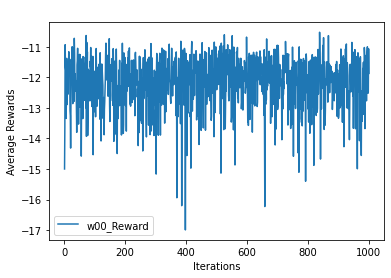

In [ ]:
filename = 'Mec'+'_w00_'
figure_file = 'plots/' + filename + '_MA.png'
x = [i+1 for i in range(0,len(data_w00))]
plot_learning_curve(x, data_w00,'w00', figure_file)

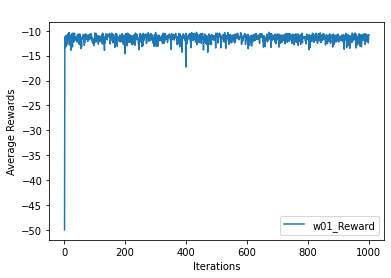

In [ ]:
filename = 'Mec'+'_w01_'
figure_file = 'plots/' + filename + '_MA.png'
x = [i+1 for i in range(0,len(data_w01))]
plot_learning_curve(x, data_w01,'w01', figure_file)

In [ ]:
aa = data_w00[900:1000]

In [ ]:
delay =[]

In [ ]:


for i in aa:
  delay.append(-i)

In [ ]:


moy = 0
for i in delay:
  moy= moy+i

moy = moy/100

In [ ]:



moy

12.212345277074496

In [ ]:
actions = loadtxt('/content/actionsw01.csv', delimiter=',')

In [ ]:
actions

array([3., 3., 3., ..., 4., 4., 4.])